In [1]:
import pandas as pd
import numpy as np
import random

from keras.applications.vgg16 import VGG16, preprocess_input
from keras import backend as K
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, flip_axis, random_shift
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from scipy.misc import imread, imresize, toimage
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# create the base pre-trained model
print(K.image_dim_ordering())
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(66,200,3))
base_model.summary()

tf
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 66, 200, 3)    0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 66, 200, 64)   1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 66, 200, 64)   36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 33, 100, 64)   0           block1_conv2[0][0]               
________________________________________________________________________________________

In [3]:
print(base_model.output)

x = base_model.output
x = GlobalAveragePooling2D()(x)  #this allows us to work with different sized images
x = Dropout(0.2)(x)
#x = Flatten(input_shape=(None, 2, 6, 512))(x)
x = Dense(100, activation="relu", name="dense_1")(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu", name="dense_2")(x)
x = Dropout(0.2)(x)
x = Dense(10, activation="relu", name="dense_3")(x)
predictions = Dense(1, activation="linear", name="dense_output")(x)

print(x.get_shape())
model = Model(input=base_model.input, output=predictions)
model.summary()

Tensor("MaxPool_4:0", shape=(?, 2, 6, 512), dtype=float32)
(?, 10)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 66, 200, 3)    0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 66, 200, 64)   1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 66, 200, 64)   36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 33, 100, 64)   0           block1_conv2[0][0]               
________________________

In [4]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in base_model.layers[:25]:
    layer.trainable = False

In [5]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss="mse", optimizer=SGD(lr=1e-4, momentum=0.9))

In [6]:
DATA_FILE = "session_data/driving_log.csv"
df = pd.read_csv(DATA_FILE, usecols=[0, 1, 2, 3, 6])

In [7]:
def read_log_file(random_drop_straight=False):
    """
    Read and process the log file that has already been opened above (in this notebook).
    A random selection is made to read either the left, center or right camera.
    
    random_drop_straight - If True will drop records with zero steering with 50% likelihood.
    Returns X, y dataset.
    """
    #from IPython.core.debugger import Tracer
    #Tracer()() #this one triggers the debugger
    
    steering_offset = 0.25
    X, y = [], []
    
    for center_img, left_img, right_img, steering_angle, speed in df.values:
        
        if random_drop_straight:
            if abs(float(steering_angle)) == 0.:
                if random.random() < 0.5:
                    continue
        
        # Randomly choose from either the left, center or right camera - this ensures an even
        # distribution of the data - this histogram above shows that otherwise we have way 
        # more straigth driving than turns...
        cam_view = np.random.choice(["center", "left", "right"])
        if cam_view == "left":
            X += [left_img.strip()]
            y += [float(steering_angle) + steering_offset]
        
        elif cam_view == "center":
            X += [center_img.strip()]
            y += [float(steering_angle)]
        
        elif cam_view == "right":
            X += [right_img.strip()]
            y += [float(steering_angle) - steering_offset]
    
    return X, y

In [8]:
def augment_brightness(image):
    """
    Apply random brightness on the image
    
    image - Numpy image (shape row, columns, colours)
    returns - Numpy image with brightness adjusted.
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    
    # scaling up or down the V channel of HSV
    image[:, :, 2] = image[:, :, 2] * random_bright
    
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    
    return image

In [9]:
def random_translation(image, steer, trans_range, trans_y=False):
    """
    Translate image and compensate for the translation on the steering angle
    
    image - Numpy image (shape: height, width, depth)
    steer - Steering angle (float)
    trans_range - The maximum range in pixles to randomly shift the image
    returns - tuple of numpy image and steering angle (float)
    """
    
    rows, cols, channels = image.shape
    
    # horizontal translation with 0.008 steering compensation per pixel
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = steer + tr_x / trans_range * .4
    
    # option to disable vertical translation (vertical translation not necessary)
    if trans_y:
        tr_y = 40 * np.random.uniform() - 40 / 2
    else:
        tr_y = 0
    
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image_tr = cv2.warpAffine(image, Trans_M, (cols, rows))
    
    return image_tr, steer_ang

In [10]:
def process_image(image_path, steering_angle, augment):
    """
    Given an image file path and associated steering angle, read in 
    the image and process it with the following augmentations:
     - random horizontal translation (with corresponding steering adjust)
     - horizontal image flipping with 50% likelihood
     - brightness augmentation
    returns - augmented numpy image and steering angle as tuple
    """
    image = load_img(image_path)
    
    #if augment and random.random() < 0.5:
    #    image = random_darken(image)  # before numpy'd
    
    image = img_to_array(image)
    
    if augment:
        #image = random_shift(image, 0, 0.2, 0, 1, 2)  # only vertical
        trans_range = 50
        image, steering_angle = random_translation(image, steering_angle, trans_range) # , trans_y=True
        
        if random.random() < 0.5:
            image = flip_axis(image, 1)
            steering_angle = -steering_angle
    
        image = augment_brightness(image)
        
    return image.astype(np.float32), steering_angle

In [11]:
def crop_and_resize(image, y1, y2, x1, x2, shape=(100, 100, 3)):
    """
    Crop and Resize images to given shape.
    
    image - numpy image to crop
    y1 - top y coord for cropping
    y2 - bottom y coord for cropping
    x1 - left x coord for cropping
    x2 - right x coord for cropping
    shape - The shape to resize the image to
    returns - cropped and reshaped numpy image
    """
    #height, width, channels = shape
    #image_resized = np.empty([height, width, channels])
    
    cropped_image = image[y1:y2, x1:x2]
    image_resized = imresize(cropped_image, shape)

    return image_resized

In [12]:
def preprocess(image):
    """
    Image pre-processing.
    Performs a crop and resize and then normalisation as per the VGG16 training!
    This must be run on all images before the model sees them when training and testing.
    
    image - numpy image
    returns - preprocessed numpy image.
    """
    # image size
    im_y = image.shape[0]
    im_x = image.shape[1]
    trans_range = 50
    
    image = crop_and_resize(image, 20, 140, 0+trans_range, im_x-trans_range, shape=(66, 200, 3))
    
    # Expand to 4D array for keras VGG16 pre-processing then return to 3D (one image)
    image_4d = np.expand_dims(image, axis=0)
    image = preprocess_input(image_4d.astype("float32"))
    
    for image_3d in image_4d:
        image = image_3d
        
    return image

In [13]:
def generator(X, y, batch_size, augment=True):
    """
    Generator function which yields batch-size lots of features.
    Each batch is determined by selecting a random index into the data and 
    processing each data row, batc_size times.
    Processing entails, reading the actual image file and applying data
    augmentation and pre-processing.
    
    X - numpy images (features)
    y - numpy array of steering values (labels)
    batch_size - the size of the batches to return
    """
    while 1:
        batch_X, batch_y = [], []
        
        for i in range(batch_size):
            sample_index = random.randint(0, len(X) - 1)
            steering_angle = y[sample_index]
            
            image, steering_angle = process_image(X[sample_index], steering_angle, augment=augment)
            
            image = preprocess(image)
            
            batch_X.append(image)
            batch_y.append(steering_angle)
            
        yield np.array(batch_X), np.array(batch_y)

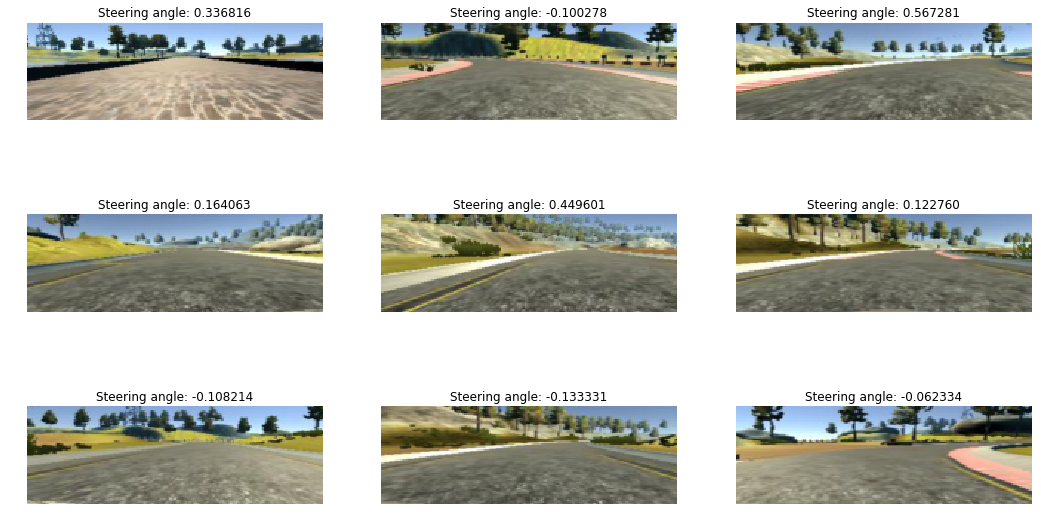

In [14]:
X, y = read_log_file(random_drop_straight=True)

plt.rcParams["figure.figsize"] = (18, 10)

for pic in range(9):
    obj = generator(X, y, batch_size=1)
    next_batch = next(obj)
    
    image_from_array = next_batch[0][0]
    #image_from_array = (image_from_array + .5) * 255 #undo the normalisation

    plt.subplot(3, 3, pic+1)
    plt.imshow(image_from_array.astype("uint8"))
    plt.axis('off')
    title = "Steering angle: {:.6f}".format(next_batch[1][0])
    plt.title(title)

Epoch 1/3
20960/20960 [==============================] - 2769s - loss: 0.1485 - val_loss: 0.0579

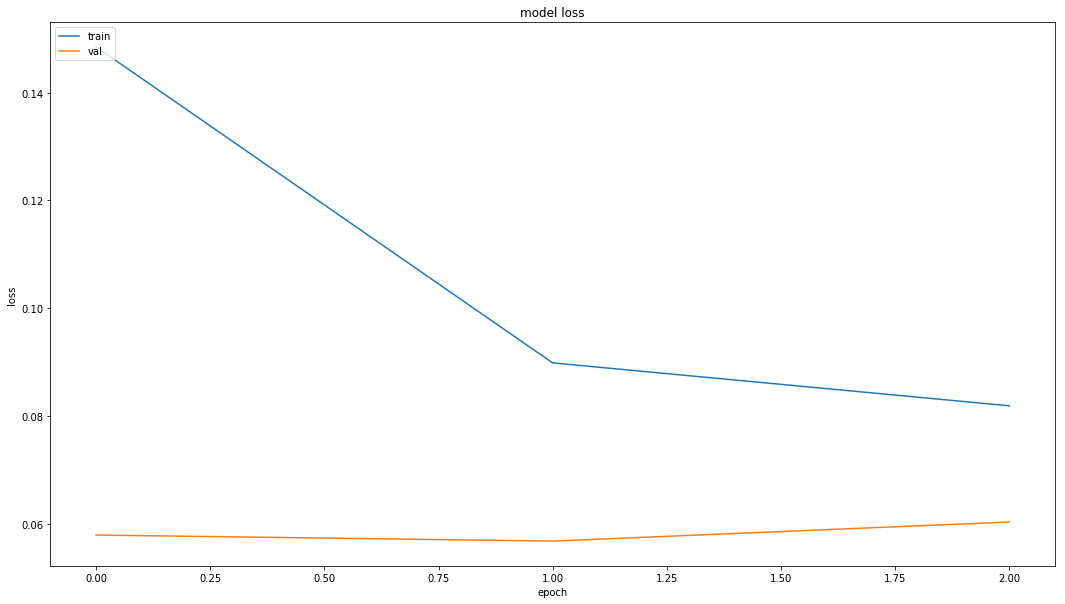

In [17]:
nb_epochs = 3
batch_size = 32

early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)
save_weights = ModelCheckpoint("save_vgg16/model.h5", monitor="val_loss", save_best_only=True, save_weights_only=True)

X, y = read_log_file(random_drop_straight=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10)

history = model.fit_generator(
    generator(X_train, y_train, batch_size),
    samples_per_epoch=(len(X_train) // batch_size) * batch_size + batch_size, # len X_train in batch size multiple
    nb_epoch=nb_epochs,
    callbacks=[early_stopping, save_weights],
    validation_data=generator(X_val, y_val, batch_size, augment=False),
    nb_val_samples=32*10)  #len(X_val))

# Summarise history for loss
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [18]:
json = model.to_json()
with open("save_vgg16/model.json", "w") as f:
    f.write(json)